In [1]:
import numpy as np

import matplotlib.pyplot as plt

import cv2
from sklearn import metrics
import threading as th
from tqdm import tqdm as progress_bar

In [4]:
!ls


Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF.jpg  README.md
projekt.ipynb					 todo.txt


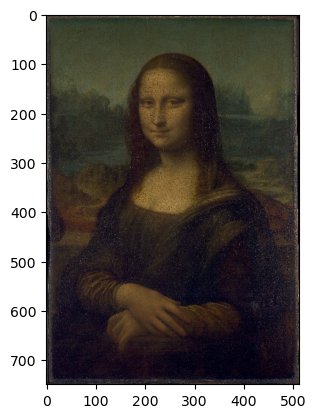

In [5]:
resize_to=512
target_img=cv2.imread('./Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF.jpg')
#Image.open('./Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF_retouched.jpg')
target_img=cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)

hw_ratio=target_img.shape[0]/target_img.shape[1]
target_img=cv2.resize(target_img, (resize_to, int(hw_ratio*resize_to))) # widtxXheight
target_img=np.asarray(target_img)/255

plt.imshow(target_img)
plt.show()

# define circles

In [6]:
class Circle:
    def __init__(self, cords, r, o, rgb, image_shape=(381, 256, 3)):
        self.x=cords[0] 
        self.y=cords[1]
        
        self.radius=r
        self.opacity=o
        self.rgb=rgb
       # self.g=rgb[1]
       # self.b=rgb[2]
        
        self.img_shape=image_shape
    def get_patch(self):
        return plt.Circle((self.x, self.y), 
                          radius=self.radius, 
                          alpha=self.opacity,
                          color=self.rgb)
    def draw_cv2(self, X):
        return cv2.circle(X, 
                  (self.x, self.y), 
                  self.radius, 
                  self.rgb,
                  thickness=-1)
        

In [7]:
def random_circle(max_radius=target_img.shape[1]):
    cords_seed=np.random.random(2)
    cords=(int(cords_seed[0]*target_img.shape[1]),
           int(cords_seed[1]*target_img.shape[0]))
    r=int(np.random.random()*100)
    o=np.random.random()
    rgb=np.random.random(3)
    return Circle(cords, r, o, rgb)

In [8]:

no_circles=100
# each circle has LOCATION (x,y), RADIUS, OPACITY, COLOUR (rgb), 
circles=[]
for i in range(no_circles):
    circles.append(random_circle())

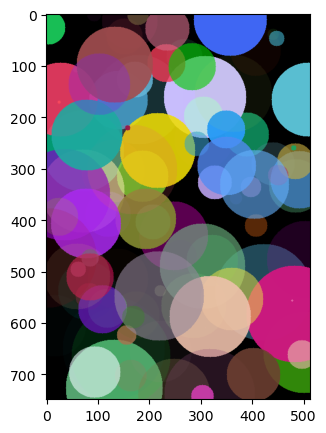

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))

X=np.zeros(target_img.shape)
for c in circles:
  #  circle_img=X.copy()
    circle_img=c.draw_cv2(X.copy())
    X=cv2.addWeighted(X, 1-c.opacity, circle_img, c.opacity, 0)

plt.imshow(X)
plt.show()

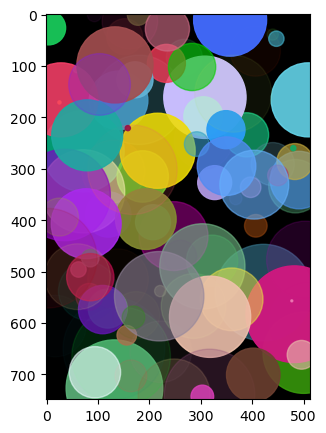

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))


X=np.zeros(target_img.shape)
ax.imshow(X)
for c in circles:
    ax.add_patch(c.get_patch())
plt.show()

# ES

In [11]:
def random_circle():
    '''Function generating random circles.
    Cirlce is presented as a numpy array lenght 7 in such scheme
    [x, y, radius, opacity, r, g, b]

    Returns:
        circle (numpy array length 7): the generated circle
    '''
    circle = np.random.random(7)
    return circle

In [12]:
def random_individual(chromosome_length, genotype_len=7):
    '''Function generating random individual.
    Args:
        chromosome_length (int): number of figures in an individual
        genotype (int): lenght of a gene (defaults 7 for circle)
    Returns:
        indiv (numpy array shaped (chromosome_length, genotype)): the generated individual
    '''
    indiv = np.zeros((chromosome_length, genotype_len))
    if genotype_len == 7: # circle
        for i in range(chromosome_length):
            indiv[i] = random_circle()
    
    return indiv

In [13]:
def random_population(population_size, chromosome_length, genotype_len=7):
    '''Function generating random population.
    Args:
        population_size (int): number of individuals in the population
        chromosome_length (int): number of figures in and individual
        genotype (int): length of a gene (defaults 7 for circle)
    
    Returns:
        population: generated population
    '''
    population = np.zeros((population_size, chromosome_length, genotype_len))
    for i in range(population_size):
        population[i] = random_individual(chromosome_length, genotype_len)
    
    return population

In [30]:
max_radius=np.sqrt(pow(target_img.shape[0],2)+pow(target_img.shape[1], 2))/2

def represent_individual(X):
    X_img=np.zeros(target_img.shape)
    for c in X:
        #[x, y, radius, opacity, r, g, b]
        x=int(c[0]*target_img.shape[1])
        y=int(c[1]*target_img.shape[0])
        radius=int(c[2]*max_radius/1.5)
        opacity=c[3]
        rgb=c[4:]
        circle_img=cv2.circle(X_img.copy(), 
                              (x, y), 
                              radius, 
                              rgb,
                              thickness=-1)
        X_img=cv2.addWeighted(X_img, 1-opacity, circle_img, opacity, 0)
    return X_img

In [16]:
def draw_individual(X_img):
    plt.imshow(X_img)
    plt.show()

In [18]:
#flatten_target_image=target_img.flatten()
def MSE_objective_f(X_img):
    #return metrics.mean_squared_error(flatten_target_image, X_img.flatten())
    pom = target_img - X_img
    return np.sum(pom*pom)

In [19]:
def mutate_X(X):
    X=np.clip(X+(np.random.random(X.shape)-0.5)*1e-1, 0, 1)
    return X

41677.04915621272


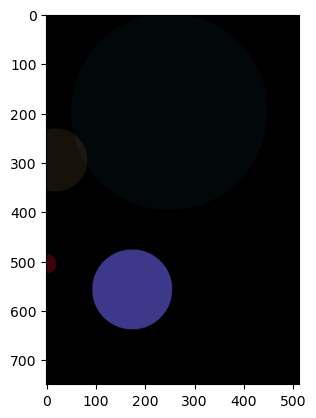

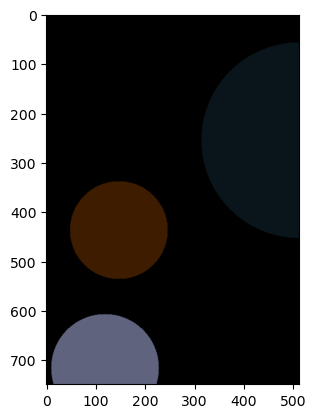

In [20]:
rpop=random_population(10, 4)
print(MSE_objective_f(represent_individual(rpop[0])))
draw_individual(represent_individual(rpop[0]))
mutated=rpop[0].copy()
for i in range(100):
    mutated=mutate_X(mutated)
draw_individual(represent_individual(mutated))

In [22]:
def evaluate_individual(evals, i, X, f):
    evals[i]=f(represent_individual(X))

In [47]:
def es(
    objective_function, 
    chromosome_length,
    genotype_length,
    population_size, 
    number_of_iterations, 
    number_of_parents, 
    number_of_offspring_per_parent=3, 
  #  sigma, 
  #  tau, 
  #  tau_0, 
    log_frequency=1,
    pararell=False
):

   # print(chromosome_length)
    best_solution = np.zeros((chromosome_length, genotype_length))
    best_solution_objective_value = np.inf

    
    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.zeros((number_of_iterations, chromosome_length, genotype_length))
   # log_best_sigmas = np.empty((number_of_iterations, chromosome_length))

    # generating an initial population
    current_population_solutions=random_population(population_size, chromosome_length, genotype_length)
   # current_population_solutions[::2]=0.5
  #  current_population_sigmas = sigma * np.ones((population_size, chromosome_length))

    # evaluating the objective function on the current population
    current_population_objective_values=np.ones(current_population_solutions.shape[0])
    if pararell:
        threads=[]
        for i in range(population_size):
            t=th.Thread(target=evaluate_individual, args=[current_population_objective_values, i,
                                                          current_population_solutions[i], objective_function])
            t.start()
            threads.append(t)
        for t in threads:
            t.join()
    else:
        current_population_objective_values = np.asarray([objective_function(represent_individual(X)) for X in current_population_solutions])
    #objective_function(current_population_solutions)
  #  print(current_population_objective_values)
    try:
        for no_iter in progress_bar(range(number_of_iterations)):

            # selecting the parent indices by the roulette wheel method
            # MAXIMIZE
            #fitness_values = current_population_objective_values - current_population_objective_values.min()
            # MINIMIZE
            fitness_values = current_population_objective_values.max() - current_population_objective_values
            if fitness_values.sum() > 0:
                fitness_values = fitness_values / fitness_values.sum()
            else:
                fitness_values = 1.0 / population_size * np.ones(population_size)
            parent_indices = np.random.choice(population_size, number_of_parents, True, fitness_values).astype(np.int64)

            # creating the children population by Global Intermediere Recombination
            children_list=[]
            for i in range(number_of_offspring_per_parent):
                children_list.append(current_population_solutions[parent_indices].copy())          
            children_population_solutions = np.vstack(children_list)
            
            for i in range(children_population_solutions.shape[0]):
                children_population_solutions[i]=mutate_X(children_population_solutions[i])
            #np.empty((number_of_offspring, chromosome_length), dtype=Circle)
            #children_population_sigmas = np.zeros((number_of_offspring, chromosome_length))

           # for i in range(number_of_offspring):
            #    children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)
             #   children_population_sigmas[i, :] = current_population_sigmas[parent_indices[i, :], :].mean(axis=0)

            # mutating the children population by adding random gaussian noise
          #  children_population_sigmas = children_population_sigmas * np.exp(tau * np.random.randn(number_of_offspring, chromosome_length) + tau_0 * np.random.randn(number_of_offspring, 1))
           # children_population_solutions = children_population_solutions + children_population_sigmas * np.random.randn(number_of_offspring, chromosome_length)

            # evaluating the objective function on the children population
            children_population_objective_values=np.ones(number_of_offspring_per_parent*number_of_parents)
            if pararell:
                threads=[]
                for i in range(children_population_solutions.shape[0]):
                    t=th.Thread(target=evaluate_individual, args=[children_population_objective_values, i,
                                                                  children_population_solutions[i], objective_function])
                    t.start()
                    threads.append(t)
                for t in threads:
                    t.join()
            else:
                children_population_objective_values = [objective_function(represent_individual(X)) for X in children_population_solutions]

            # replacing the current population by (Mu + Lambda) Replacement
            current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
            current_population_solutions = np.vstack([current_population_solutions, children_population_solutions])
           # current_population_sigmas = np.vstack([current_population_sigmas, children_population_sigmas])

            I = np.argsort(current_population_objective_values)#[::-1]
            current_population_solutions = current_population_solutions[I[:population_size], :]
        #    current_population_sigmas = current_population_sigmas[I[:population_size], :]
            current_population_objective_values = current_population_objective_values[I[:population_size]]

            # recording some statistics
            if best_solution_objective_value > current_population_objective_values[0]:
                best_solution = current_population_solutions[0, :]
                best_solution_objective_value = current_population_objective_values[0]

         #   print(no_iter, current_population_objective_values.min(), 
        #          current_population_objective_values.max(), 
         #         current_population_objective_values.mean(), 
        #          current_population_objective_values.std())
            log_objective_values[no_iter, :] = [current_population_objective_values.min(), 
                                                current_population_objective_values.max(),
                                                current_population_objective_values.mean(), 
                                                current_population_objective_values.std()]

           # print(log_best_solutions.shape, current_population_solutions.shape )
            log_best_solutions[no_iter, :] = current_population_solutions[0, :]

           # log_best_sigmas[t, :] = current_population_sigmas[0, :]

            if np.mod(no_iter+1, log_frequency) == 0:
                print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (no_iter, 
                                                                                    log_objective_values[:no_iter+1, 0].min(), 
                                                                                    log_objective_values[no_iter, 2]))
    except KeyboardInterrupt:
        print('Interrupted')
    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions

In [48]:
'''def es(
    objective_function, 
    individual_size,
    population_size, 
    number_of_iterations, 
    number_of_parents, 
number_of_offspring_per_parent  #  sigma, 
  #  tau, 
  #  tau_0, 
    log_frequency=1
):'''

best_solution_objective_value, best_solution, \
log_objective_values, log_best_solutions=es(MSE_objective_f, 
                                             chromosome_length=128,
                                             genotype_length=7,
                                             population_size=64,
                                            number_of_iterations=100,
                                            number_of_parents=16,
                                            number_of_offspring_per_parent=4,
                                            pararell=True, log_frequency=10)

 10%|████▏                                     | 10/100 [03:24<30:33, 20.38s/it]

Iteration 0009 : best score = 37395.41152032, mean score = 43449.43911974.


 20%|████████▍                                 | 20/100 [06:48<27:12, 20.40s/it]

Iteration 0019 : best score = 24321.59563456, mean score = 28503.56831110.


 30%|████████████▌                             | 30/100 [10:12<23:50, 20.44s/it]

Iteration 0029 : best score = 13924.80950169, mean score = 16599.04969173.


 40%|████████████████▊                         | 40/100 [13:36<20:24, 20.42s/it]

Iteration 0039 : best score = 12409.24783886, mean score = 13714.81541309.


 50%|█████████████████████                     | 50/100 [17:01<17:02, 20.46s/it]

Iteration 0049 : best score = 11858.61799074, mean score = 12677.90552433.


 60%|█████████████████████████▏                | 60/100 [20:26<13:37, 20.44s/it]

Iteration 0059 : best score = 11276.40474015, mean score = 11966.54015979.


 70%|█████████████████████████████▍            | 70/100 [23:50<10:11, 20.40s/it]

Iteration 0069 : best score = 10588.12358922, mean score = 11314.75749265.


 80%|█████████████████████████████████▌        | 80/100 [27:14<06:48, 20.41s/it]

Iteration 0079 : best score = 9873.82275512, mean score = 10602.15268786.


 90%|█████████████████████████████████████▊    | 90/100 [30:38<03:23, 20.39s/it]

Iteration 0089 : best score = 8721.45219906, mean score = 9758.71555527.


100%|█████████████████████████████████████████| 100/100 [34:02<00:00, 20.42s/it]

Iteration 0099 : best score = 8632.10701639, mean score = 9272.04976497.


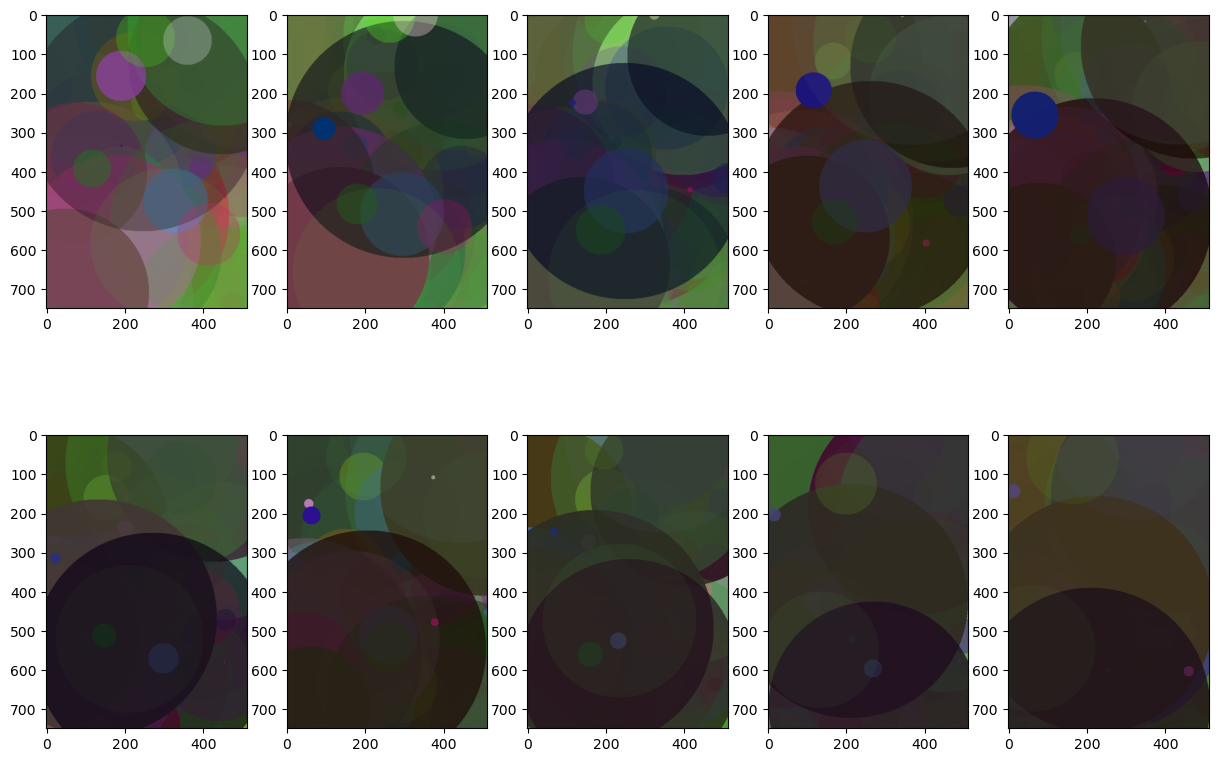

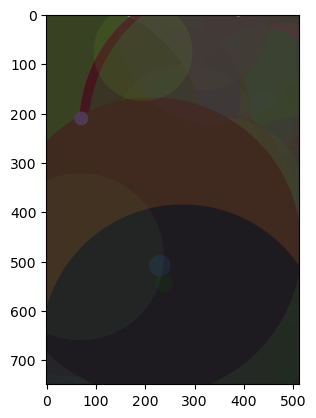

In [49]:

fig, axs = plt.subplots(log_best_solutions.shape[0]//50, 5, figsize=(15,10))
col_counter=0
row_counter=0
for i, X in enumerate(log_best_solutions):
    if i%10==0:
        axs[row_counter, col_counter].imshow(represent_individual(X))
        col_counter+=1
        if col_counter>4:
            col_counter=0
            row_counter+=1
        #draw_individual(represent_individual(X))
plt.show()
draw_individual(represent_individual(best_solution))